Main with CO2 absorption.

In [614]:
from System_matrix import N_layer_system
from System_solve import solve_N_layer, solve_Temps
from Real_atmosphere import read_atmosphere
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


CO2_spectrum=np.loadtxt("CO2_ppm400_spec100000_4um_100um_N50_US.csv", delimiter=",")
H2O_spectrum=np.loadtxt("H2O_ppm400_spec100000_4um_100um_N50_US.csv", delimiter=",")
O3_spectrum=np.loadtxt("O3_alpha_layer_100000_4um_100um_0-50km_US.csv", delimiter=",")
N2O_spectrum=np.loadtxt("N2O_alpha_layer_100000_4um_100um_0-50km_US.csv", delimiter=",")
CH4_spectrum=np.loadtxt("CH4_alpha_layer_100000_4um_100um_0-50km_US.csv", delimiter=",")
Band_interval=np.linspace(4,100,100000)

In [615]:
###Supporting functions

import numpy as np

def planck_spec(T_surface,Band_centers): #
    h  = 6.62607015e-34      # Planck constant [J s]
    c  = 2.99792458e8        # speed of light [m/s]
    kB = 1.380649e-23        # Boltzmann constant [J/K]
    lam_interp=Band_centers*10**(-6)
 
    # Planck's law for spectral radiance
    B_lam = (2*h*c**2) / (lam_interp**5) * 1 / (np.exp(h*c/(lam_interp*kB*T_surface)) - 1)  # [W/m^2/m/sr]

    E_lam_m = B_lam * np.pi  # Spectral irradiance [W/m^2/m]
    Earth_spectrum = E_lam_m * 1e-6  # Convert to W/m^2/um, to use in CO2 absorption
    
    return Earth_spectrum

def black_body_spectrum(T_surface,Band_centers): #
    h  = 6.62607015e-34      # Planck constant [J s]
    c  = 2.99792458e8        # speed of light [m/s]
    kB = 1.380649e-23        # Boltzmann constant [J/K]
    lam_interp=Band_centers*10**(-6)
 
    # Planck's law for spectral radiance
    B_lam = (2*h*c**2) / (lam_interp**5) * 1 / (np.exp(h*c/(lam_interp*kB*T_surface)) - 1)  # [W/m^2/m/sr]

    E_lam_m = B_lam * np.pi  # Spectral irradiance [W/m^2/m]
    Earth_spectrum = E_lam_m * 1e-6  # Convert to W/m^2/um, to use in CO2 absorption
    
    power_band=(Band_centers[1]-Band_centers[0])*E_lam_m*1e-6
    return power_band #Energi in interval

def eps_g(tau, B_lambda, wavelengths):
    
    num = np.trapz((1-np.exp(-tau)) * B_lambda, wavelengths)
    den = np.trapz(B_lambda, wavelengths)
    return num / den  


def solve_fit_atmosphere(E,M):
    sigma = 5.670374419e-8
    Q=np.linalg.solve(M,E)
    T=abs((Q/sigma))**0.25
    return Q,T


def spectrum_to_eps_combined_tau(tau): #dz because current data i lin.space in height
    ### dz in [cm] n_CO2 [molecule/cm^3], spectrum [cm^2/molecule]
    
    
    eps=np.zeros([len(tau[:,0]),len(tau[0])])
    for i in range(len(tau[:,0])):#Rows are height
        for j in range(len(tau[0])): #Columns are spectra values
            eps[i][j]=1-np.exp(tau[i][j])
        print(i)
    eps0=np.zeros(len(tau[0]))
    eps=np.vstack([eps0,eps])
    eps[0]=np.ones(len(tau[0]))
    
    return eps

def spectrum_to_eps_combined(spectrum_CO2,spectrum_H2O,spectrum_O3,spectrum_N2O,spectrum_CH4, n_CO2_mid, n_H2O_mid,n_03_mid,n_N2O_mid,n_CH4_mid, dz): #dz because current data i lin.space in height
    ### dz in [cm] n_CO2 [molecule/cm^3], spectrum [cm^2/molecule]
    
    tau=np.zeros([len(spectrum_CO2[:,0]),len(spectrum_CO2[0])])
    eps=np.zeros([len(spectrum_CO2[:,0]),len(spectrum_CO2[0])])
    for i in range(len(spectrum_CO2[:,0])):#Rows are height
        for j in range(len(spectrum_CO2[0])): #Columns are spectra values
            tau[i,j]=(spectrum_CO2[i][j]*n_CO2_mid[i]+spectrum_H2O[i][j]*n_H2O_mid[i]+spectrum_O3[i][j]*n_03_mid[i]+spectrum_N2O[i][j]*n_N2O_mid[i]+spectrum_CH4[i][j]*n_CH4_mid[i])*dz
            eps[i][j]=1-np.exp(-tau[i,j])
        #print(i)
    eps0=np.zeros(len(spectrum_CO2[0]))
    eps=np.vstack([eps0,eps])
    eps[0]=np.ones(len(spectrum_CO2[0]))
    
    return eps, tau

def eps_to_grey(tau, B_lambda, wavelengths):
    
    num = np.trapz((1-np.exp(-tau)) * B_lambda, wavelengths)
    den = np.trapz(B_lambda, wavelengths)
    return num / den

def convective_adjustment(eps_grey,Gamma,E_in_SW_tot,stepscale=0.01,system=N_layer_system_convective):
    c=np.array([0])
    zeros=np.zeros(len(z_interp)-len(c))
    c=np.concatenate((c,zeros))
    M_con=system(eps_grey,c)
    Q_con,T_con=solve_fit_atmosphere(-E_in_SW_tot,M_con)
    Q_con_old=np.zeros(len(Q_con))
    time=0
    while np.any(-np.diff(T_con)>Gamma): #for this I know dz=1km
        
        for i in range(len(T_con)-1):
            if (T_con[i]-T_con[i+1])>Gamma[i]:
                c[i]=c[i]+stepscale*(Q_con[i]-Q_con[i+1])/Q_con[i] #Proportional to flux difference
                break
            if c[i]==0:
                break
            #Runs entire loop no need though but is ok for now.
        M_con=system(eps_grey,c)
        Q_con,T_con=solve_fit_atmosphere(-E_in_SW_tot,M_con)
        
        #Check if change
        Q_con_change=Q_con-Q_con_old
        if np.max(np.abs(Q_con_change))<1e-6:
            break
        Q_con_old=Q_con
        
        time+=1
    return T_con,c,time,M_con

In [ ]:



def initialize_atmosphere(file="Standard_Atmospheres/us_standard.csv",height=50,dz=1000,CO2PPM=400): #dz input in meters

    z_interp, O3_interp, T_real, p_real, n_air,H2Oppm,N2Oppm,CH4ppm= read_atmosphere(file=file,height=height,dz=dz)
    mid_air=n_air[:-1]+np.diff(n_air)/2
    mid_H2Oppm=H2Oppm[:-1]+np.diff(H2Oppm)/2
    mid_N2Oppm=N2Oppm[:-1]+np.diff(N2Oppm)/2
    mid_CH4ppm=CH4ppm[:-1]+np.diff(CH4ppm)/2
    mid_preal=p_real[:-1]+np.diff(p_real)/2
    mid_Treal=T_real[:-1]+np.diff(T_real)/2
    mid_O3=O3_interp[:-1]+np.diff(O3_interp)/2
    CO2ppm=np.ones(len(mid_H2Oppm))*CO2PPM
    dz=1000*100 #in cm
    n_CO2_mid=mid_air*CO2ppm*1e-6*1e-6 #in molecules/cm^3
    n_H2O_mid=mid_air*mid_H2Oppm*1e-6*1e-6 #in molecules/cm^3
    n_N2O_mid=mid_air*mid_N2Oppm*1e-6*1e-6
    n_CH4_mid=mid_air*mid_CH4ppm*1e-6*1e-6 #in molecules/cm^3
    n_03_mid=mid_O3*1e-6 #artifact from function
    mid_Treal_t=np.concatenate([[T_real[0]],mid_Treal])
    return T_real, mid_Treal,mid_Treal_t, mid_preal, n_CO2_mid, n_H2O_mid, n_03_mid, n_N2O_mid, n_CH4_mid,z_interp, dz

T_real, mid_Treal,mid_Treal_t, mid_preal, n_CO2_mid, n_H2O_mid, n_03_mid, n_N2O_mid, n_CH4_mid,z_interp, dz=initialize_atmosphere(file="Standard_Atmospheres/us_standard.csv",height=50,dz=1000,CO2PPM=400)
S=1370 # Solar constant W/m2
A=0.3 # Albedo of the surface
eps_spec,tau_5_spec=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, n_CO2_mid,n_H2O_mid,n_N2O_mid,n_CH4_mid,n_03_mid, dz)
eps=eps_spec
tau_5=tau_5_spec
print(eps_spec.shape)


E_in_SW_US=np.loadtxt("E_SW_R1_tot_abs_US_albedo_0.1.csv", delimiter=",")
E_in_SW_S45=np.loadtxt("E_SW_R1_tot_abs_S45_albedo_0.1.csv", delimiter=",")
E_in_SW_W45=np.loadtxt("E_SW_R1_tot_abs_W45_albedo_0.1.csv", delimiter=",")
E_in_SW_15N=np.loadtxt("E_SW_R1_tot_abs_15N_albedo_0.1.csv", delimiter=",")
E_in_SW_S60=np.loadtxt("E_SW_R1_tot_abs_S60_albedo_0.1.csv", delimiter=",")
E_in_SW_W60=np.loadtxt("E_SW_R1_tot_abs_W60_albedo_0.1.csv", delimiter=",")
#For eaiser calc make tot 240 W/m2
E_in_SW_US=np.concatenate([[240-np.sum(E_in_SW_US)],E_in_SW_US]) 
E_in_SW_S45=np.concatenate([[240-np.sum(E_in_SW_S45)],E_in_SW_S45])
E_in_SW_W45=np.concatenate([[240-np.sum(E_in_SW_W45)],E_in_SW_W45])
E_in_SW_15N=np.concatenate([[240-np.sum(E_in_SW_15N)],E_in_SW_15N])
E_in_SW_S60=np.concatenate([[240-np.sum(E_in_SW_S60)],E_in_SW_S60])
E_in_SW_W60=np.concatenate([[240-np.sum(E_in_SW_W60)],E_in_SW_W60])


(51, 100000)


In [617]:
print(np.sum(E_in_SW_US[1:]))

51.24288472560745


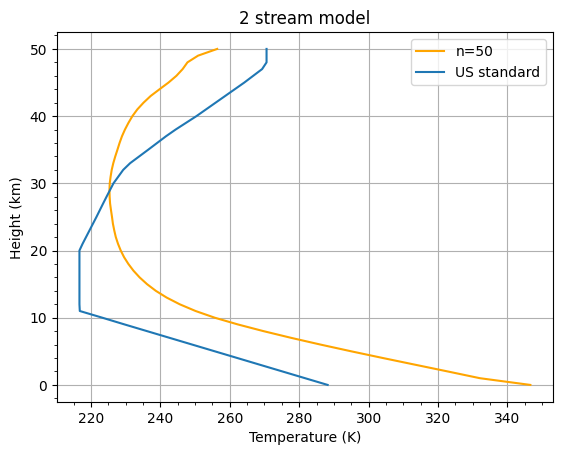

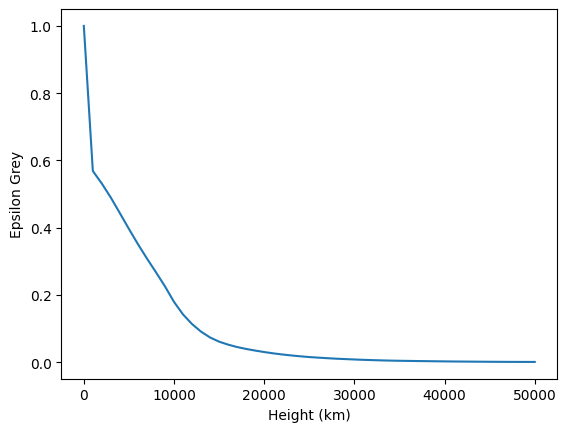

[1.         0.56876058 0.53124528 0.4894238  0.44327973 0.39660147
 0.35127227 0.30853362 0.26770827 0.22570935 0.17966434 0.14231975
 0.11370636 0.09113782 0.07384457 0.06136073 0.05255404 0.04542026
 0.03977084 0.03491688 0.03055939 0.02668298 0.02332891 0.02044381
 0.01789319 0.01566103 0.01389578 0.01227214 0.01077942 0.00956478
 0.0084439  0.00738886 0.00652147 0.00573093 0.00509946 0.00457761
 0.00416707 0.00380796 0.00344316 0.00310176 0.00276595 0.00247669
 0.00224234 0.00201369 0.00181489 0.00162825 0.00146304 0.00132367
 0.00121443 0.00117713 0.00117713]
[188.75711527   5.81392359   5.54422024   5.18005018   4.64427565
   4.10572495   3.55863377   3.0515288    2.59844001   2.0225708
   1.25548044   0.82212061   0.60001293   0.45948636   0.37611472
   0.34528286   0.34287707   0.35675035   0.38292717   0.40504749
   0.42725267   0.43959842   0.44166791   0.44343933   0.43201426
   0.41834673   0.39843637   0.37236993   0.34905326   0.33008491
   0.3126955    0.29716098   0.283

In [618]:

eps_grey=np.zeros(len(T_real))
eps_grey[0]=1
for i in range(len(mid_Treal)):
    eps_grey[i+1]=eps_to_grey(tau_5[i],planck_spec(mid_Treal[i],Band_interval),Band_interval)
#Calc the system

M=N_layer_system(eps_grey)
Q,T=solve_fit_atmosphere(E_in_SW_US,M)

plt.plot(T,z_interp/1000,label='n=50',color='orange')
plt.plot(T_real,z_interp/1000,label='US standard')
#plt.plot(T_con,z_interp/1000,label='n=50 convection',color='black')
plt.minorticks_on()
plt.grid()
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Height (km)')
plt.title('2 stream model')
plt.show()

plt.plot(z_interp,eps_grey)
plt.xlabel('Height (km)')
plt.ylabel('Epsilon Grey')
plt.show()

print(eps_grey)
print(E_in_SW_US)


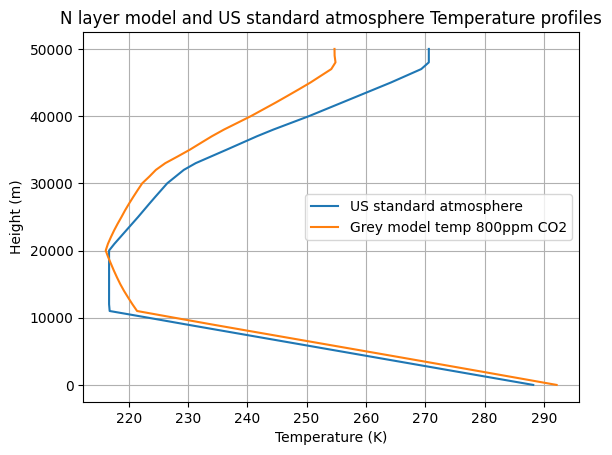

[  3.94032218   4.07100957   4.18309235   4.25160869   4.29100271
   4.30928247   4.31201662   4.30636925   4.30359278   4.3242116
   4.40015307   4.62091816   3.938059     3.21394551   2.5139647
   1.88744108   1.33355727   0.81452205   0.33085431  -0.14678669
  -0.56921671  -1.09048524  -1.58864421  -2.0472669   -2.447465
  -2.8053013   -3.15140213  -3.43767745  -3.70722342  -3.97324311
  -4.2148719   -4.42059104  -4.70958681  -5.12581572  -5.62663565
  -6.19431774  -6.90449683  -7.59978806  -8.32903815  -9.05745437
  -9.78884517 -10.47789509 -11.16775936 -11.93252968 -12.72089925
 -13.55359982 -14.36005684 -15.16240389 -15.73085275 -15.88089712
 -15.89832823]
[-60.59640756 -15.52267021  -8.78914472  -6.85576505  -6.30302958
  -5.87258298  -5.15640766  -4.08261864  -2.68022191  -0.98964817
   0.70130188   2.24737872  -0.06639861  -1.23079002  -1.74896242
  -1.96190681  -2.04886508  -2.04644275  -2.00385002  -1.92389034
  -1.81109186  -1.79235795  -1.75347054  -1.69336185  -1.61430723

In [619]:
#PERF fit
eps_2xCO2,tau_5_2xCO2=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, n_CO2_mid*2,n_H2O_mid,n_N2O_mid,n_CH4_mid,n_03_mid, dz)
eps_grey_2xCO2=np.zeros(len(T_real))
eps_grey_2xCO2[0]=1
for i in range(len(mid_Treal)):
    eps_grey_2xCO2[i+1]=eps_to_grey(tau_5_2xCO2[i],planck_spec(mid_Treal[i],Band_interval),Band_interval)

M_2xCO2=N_layer_system(eps_grey_2xCO2)

sigma = 5.670374419e-8
E_perf=(M*sigma)@T_real**4
Q_perf,T_perf=solve_fit_atmosphere(E_perf,M)
Q_perf_2xCO2,T_perf_2xCO2=solve_fit_atmosphere(E_perf,M_2xCO2)

Q,T=solve_fit_atmosphere(E_in_SW_US,M)
Q_2xCO2,T_2xCO2=solve_fit_atmosphere(E_in_SW_US,M_2xCO2)
plt.plot(T_perf,z_interp,label='US standard atmosphere')
plt.plot(T_perf_2xCO2,z_interp,label='Grey model temp 800ppm CO2')

#plt.plot(T,z_interp,label='Grey model temp 400ppm CO2 SW input')
#plt.plot(T_2xCO2,z_interp,label='Grey model temp 800ppm CO2 SW input')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Height (m)')
plt.title('N layer model and US standard atmosphere Temperature profiles')
plt.grid()
plt.show()
print(T_perf_2xCO2-T_perf)
print(E_perf)

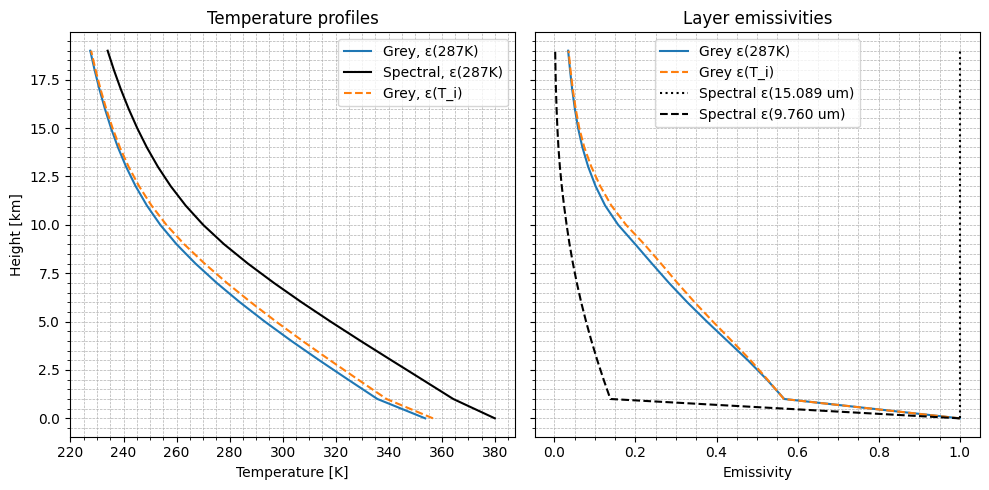

9.760057600576005


In [620]:


eps_grey = np.zeros(len(z_interp)-1)
for i in range (len(z_interp)-1):
    eps_grey[i]=eps_g(tau_5_spec[i],planck_spec(T_surface,Band_interval),Band_interval)
eps_grey=np.concatenate(([np.array([1]),eps_grey]))#Surface emissivity 1
M=N_layer_system(eps_grey)
Q=solve_N_layer(E_in_tot,eps_grey,M)
T_grey=solve_Temps(Q)


eps_grey_change = np.zeros(len(z_interp)-1)
for i in range (len(z_interp)-1):
    eps_grey_change[i]=eps_g(tau_5_spec[i],planck_spec(mid_Treal_t[i],Band_interval),Band_interval)
eps_grey_change=np.concatenate(([np.array([1]),eps_grey_change]))#Surface emissivity 1
M=N_layer_system(eps_grey_change)
Q=solve_N_layer(E_in_tot,eps_grey_change,M)
T_grey_change=solve_Temps(Q)

import numpy as np
import matplotlib.pyplot as plt

# z_interp in meters → convert to km
z_km = z_interp / 1000.0

# If emissivities are per layer, define mid-layer heights


fig, (axT, axE) = plt.subplots(
    1, 2, figsize=(10, 5), sharey=True  # share the height axis
)

# --- Left: temperature profiles ---
axT.plot(T_grey[0:20], z_km[0:20], label="Grey, ε(287K)")
axT.plot(Temps[0:20], z_km[0:20], color="black",label="Spectral, ε(287K)")
axT.plot(T_grey_change[0:20], z_km[0:20], "--", label="Grey, ε(T_i)")

axT.set_xlabel("Temperature [K]")
axT.set_ylabel("Height [km]")
axT.set_title("Temperature profiles")

#add more grid lines
axT.minorticks_on()
axT.grid(which='both', linestyle='--', linewidth=0.5)
axT.legend()

# --- Right: emissivity profiles ---
axE.plot(eps_grey[0:20], z_km[0:20], label="Grey ε(287K)")
axE.plot(eps_grey_change[0:20], z_km[0:20], "--", label="Grey ε(T_i)")
#make differnt line than "--" make small circles

axE.plot(eps_spec[0:20,11551], z_km[0:20],linestyle="dotted", color='black', label="Spectral ε(15.089 um)")
axE.plot(eps_spec[0:20,6000], z_km[0:20],linestyle="dashed" ,color='black', label="Spectral ε(9.760 um)")

axE.set_xlabel("Emissivity")
axE.set_title("Layer emissivities")
axE.minorticks_on()
axE.grid(which='both', linestyle='--', linewidth=0.5)
axE.legend()

# Atmosphere convention: height increasing upward


plt.tight_layout()
plt.show()

print(Band_interval[6000])

(51, 51)
[232.32344843 233.78284581 235.60851304 237.71566836 240.30949913
 242.93125847 245.21035606 246.99297728 248.3640285  251.44633147
 257.03481402]
[0.1489554  0.12748153 0.11779312 0.10894426 0.09689829 0.08104182
 0.06184568 0.04149102 0.02286377 0.00798209 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
[232.32344843 233.78284581 235.60851304 237.71566836 240.30949913
 242.93125847 245.21035606 246.99297728 248.3640285  251.44633147
 257.03481402]
813


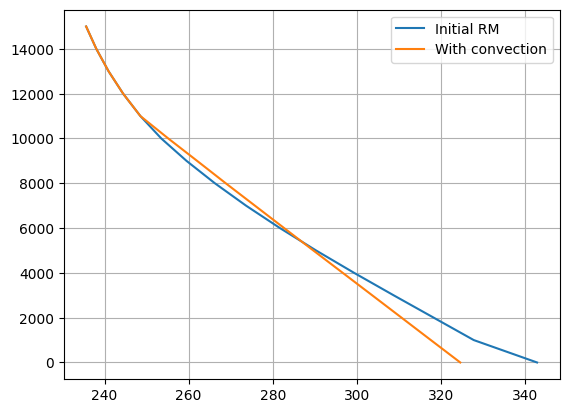

In [621]:
### Convective Coefficients in system. c_i*T_i

def N_layer_system_convective(Eps,c): #Eps[0]=1 to work properly
    Eps[0]=1
    N=len(Eps)
    t=1-Eps
    accuracy=1e-7
    # Epsilon cant be 1 or 0, singular matrix otherwise 
    for i in range(len(Eps)-1):
        if (Eps[i+1]<=accuracy):
            Eps[i+1]=accuracy
        elif (Eps[i+1]>=1-accuracy):
            Eps[i+1]=1-accuracy
            
    M=[]
    for n in range(N): #number of rows
        row = np.zeros(N)
        for i in range(N): #making the columns.
            
            if i > n:
                row[i]=math.prod(t[n+1:i])*Eps[i]*Eps[n] #multiplying the Epsilons together between each transmission layer
                if i-n == 1:
                    row[i]=Eps[i-1]*Eps[i]
            elif n == 0 and i == 0:
                row[i]=(-1)*Eps[i]
            
            elif i == n and n!=0:
                row[i]=(-2)*Eps[i]
            
            
        M.append(row)
    M=np.array(M)   

    #It is symetric so make M[1][0] = M[0][1] and so on.
    #I transpose the matrix and add it to itself and then subtract the diagonal.
    M_transpose = np.transpose(M)
    M = np.array(M) + M_transpose - np.diag(np.diag(M))
    
    for i in range(N-1):#Add convective coefficients
        M[i,i]=M[i,i]-c[i]
        M[i+1,i]=M[i+1,i]+c[i]
    return M
print(M.shape)

#Make concvective time loop to find c coefficients
c=np.array([0])
zeros=np.zeros(len(z_interp)-len(c))
c=np.concatenate((c,zeros))
M_con=N_layer_system_convective(eps_grey,c)
Q_con,T_con=solve_fit_atmosphere(-E_in_SW_US,M_con)
plt.plot(T_con[:16],z_interp[:16],label='Initial RM')
print(T_con[40:])

#Calculate convective adjustment
T_con,c,time,M_con=convective_adjustment(eps_grey,Gamma=np.ones(len(eps_grey)-1)*7,E_in_SW_tot=E_in_SW_US,stepscale=0.01,system=N_layer_system_convective)
    
print(c)

plt.plot(T_con[:16],z_interp[:16],label='With convection')
plt.legend()
plt.grid()
print(T_con[40:])

print(time)


0.010133034544298716


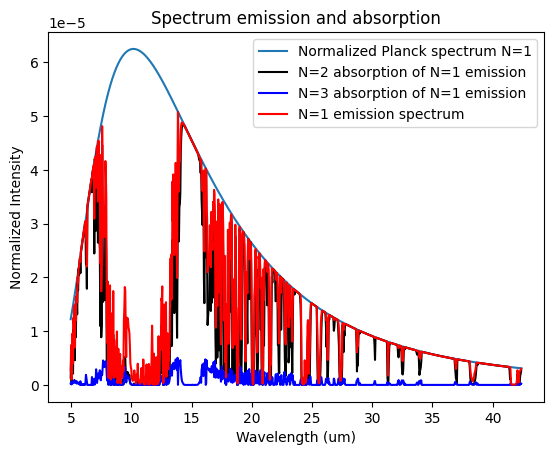

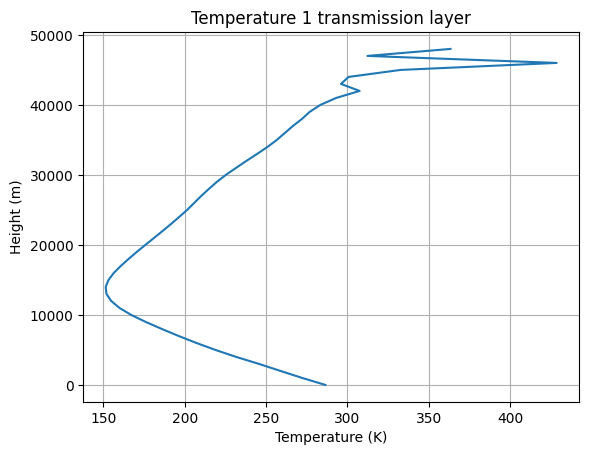

[[1.         1.         1.         1.         1.        ]
 [0.04194165 1.         0.04170714 1.         1.        ]
 [1.         0.0231587  1.         0.0233139  1.        ]
 [1.         1.         0.02229318 1.         0.02246743]
 [1.         1.         1.         0.02148788 1.        ]]
[[1.         1.         1.         1.        ]
 [1.         1.         1.         0.01815228]
 [0.01858364 1.         1.         1.        ]
 [1.         0.0082459  1.         1.        ]]
[[-1.          0.56876058  0.04170714  0.01815228  0.00963599]
 [ 0.56611532 -1.13752116  0.4895375   0.0233139   0.00824047]
 [ 0.04194165  0.48398583 -1.06249055  0.44795716  0.02246743]
 [ 0.01858364  0.0231587   0.44230498 -0.9788476   0.40293584]
 [ 0.          0.0082459   0.02229318  0.39727144 -0.88655945]] First 4x4
[1. 1. 1. ... 1. 1. 1.]
286.4052191070827


In [622]:
#Try to makediffertn epsilon based on their overlap. Giving a higher downward epsilon.
#The Flux doe'nt change the lower atmosphere as much.


def N_layer_system_dif_t1(Eps,Eps_t1,Eps_t2): #Eps[0]=1 to work properly
    
    N=len(Eps)
    ones=np.ones_like(Eps)
    t=ones-Eps
    accuracy=1e-5
    # Epsilon cant be 1 or 0, singular matrix otherwise 
    for i in range(len(Eps)-1):
        for j in range(len(Eps)-1):
            if (Eps[i+1,j+1]<=accuracy):
                Eps[i+1,j+1]=accuracy
            elif (Eps[i+1,j+1]>=1-accuracy):
                Eps[i+1,j+1]=1-accuracy
            
    M=np.zeros_like(Eps,dtype=np.float64)
    #Only put in transmissions of lates in EPS
    eps_diag=np.diag(Eps)
    t_diag=1-eps_diag
    
    for i in range(N): #number of rows
        for j in range(N): #making the columns.
            #Under diagonal
            if j > i:
                    #transmission of emission from higher layers. Absorbed in lower. Emission Eps[j,j]
                if j-i == 1:
                    M[i,j]=Eps[i,j]
                if j-i == 2:
                    M[i,j]=Eps_t1[i+1,j]
                if j-i==3:
                    M[i,j]=Eps_t2[i+1,j]
                
            elif i == 0 and j == 0:
                M[i,j]=(-1)*Eps[i,j]
            
            elif j == i and i!=0:
                M[i,j]=(-2)*Eps[i,j]  
            
            #above diagonal
            if j < i:
                if i-j == 1:
                    M[i,j]=Eps[i,j]
                if i-j == 2:
                    M[i,j]=Eps_t1[i-1,j]   
                if i-j ==3:
                    M[i,j]=Eps_t2[i-1,j]  
                
    for i in range(N): #number of rows
        for j in range(N): #making the columns.
            if j>i:
                if j-i==4:
                    M[i,j]=-(M[j,j]/2+M[i+1,j]+M[i+2,j]+M[i+3,j])
    #M[4,0]=np.sum((surface_emi-(abs_t2+abs_t1+abs_t0))*eps_spec[4,:])       
    return M
c_dif=c*0

### Make epsilon_grey differnt for corelation of spectal overlap



eps_grey_dif=np.ones([len(T_real),len(T_real)],dtype=np.float64)#make 64 bit
#eps_grey_dif[0,:]=np.ones(len(T_real))
eps_weight_own=np.zeros_like(eps_spec,dtype=np.float64)
eps_weight_own_t1=np.zeros_like(eps_spec,dtype=np.float64)
for i in range(1,len(T_real)): #Fill rows with weighted epsilons. How well does it absorb energi at a temperature
    eps_weight_own[i,:]=(eps_spec[i]*planck_spec(mid_Treal[i-1],Band_interval))/np.sum(planck_spec(mid_Treal[i-1],Band_interval)) #Emitted spectrum energi ratio released
    eps_weight_own_t1[i,:]=(eps_spec[i]*planck_spec(mid_Treal[i-1],Band_interval))/np.sum(planck_spec(mid_Treal[i-1],Band_interval)) #
    
    
    if i ==1:
        #plt.plot(Band_interval,eps_weight_own[i,:])
        #norm_spec=eps_spec[i]/np.sum(eps_spec[i])
        emi=(eps_spec[i]*planck_spec(mid_Treal[i-1],Band_interval))/np.sum(planck_spec(mid_Treal[i-1],Band_interval)) #area equal to absorped ratio
        planck=planck_spec(mid_Treal[i-1],Band_interval)/np.sum(planck_spec(mid_Treal[i-1],Band_interval))
        mean_emi=[]
        for k in range(np.floor(len(emi[1000:40000])/40).astype(int)):
            int_emi=np.mean(emi[1000+k*40:1000+(k+1)*40])
            mean_emi.append(int_emi)
        #plt.plot(Band_interval[1000:40000:40],mean_emi)
        plt.plot(Band_interval[1000:40000],planck[1000:40000],label="Normalized Planck spectrum N=1")
    #Normalised np.sum(eps_weight_own)=1

#plt.show()
#eps_spec shape 51x100000 tau 50x100000
trans1=np.zeros_like(eps_spec,dtype=np.float64)
eps_grey_dif_t1=np.ones_like(eps_grey_dif,dtype=np.float64)
eps_grey_dif_t2=np.ones_like(eps_grey_dif,dtype=np.float64)
for i in range(1,len(T_real)): # Loop over layers
    for j in range(1,len(T_real)):# Loop over combinations
        if i==j:
            eps_grey_dif[i,j]=eps_to_grey(tau_5_spec[i-1],planck_spec(mid_Treal[i-1],Band_interval),Band_interval) #regular grey
        else:
            eps_grey_dif[i,j]=np.sum(eps_spec[i,:]*eps_weight_own[j,:]) #ROW is absorbed ratio for emitting layer j 
            if j-i==1 and i<(len(T_real)-1) and j<(len(T_real)-1):
                abs_t0_under=eps_spec[i,:]*eps_weight_own[j,:]
                abs_t1_under=(eps_weight_own[j,:]-abs_t0_under)*eps_spec[i-1,:]
                eps_grey_dif_t1[i,j]=np.sum(abs_t1_under) #scaled =1
                
            if j-i==2 and i<(len(T_real)-1) and j<(len(T_real)-1):
                abs_t0_under=eps_spec[i+1,:]*eps_weight_own[j,:]
                abs_t1_under=(eps_weight_own[j,:]-abs_t0_under)*eps_spec[i,:]
                eps_grey_dif_t2[i,j]=np.sum((eps_weight_own[j,:]-(abs_t1_under+abs_t0_under))*eps_spec[i-1])
                    
            if i-j==1 and i<(len(T_real)-1) and j<(len(T_real)-1):
                abs_t0_over=eps_spec[i,:]*eps_weight_own[j,:]
                abs_t1_over=(eps_weight_own[j,:]-abs_t0_over)*eps_spec[i+1,:]
                eps_grey_dif_t1[i,j]=np.sum(abs_t1_over) #scaled =1
                
            if i-j==2 and i<(len(T_real)-1) and j<(len(T_real)-1):
                abs_t0_over=eps_spec[i-1,:]*eps_weight_own[j,:]
                abs_t1_over=(eps_weight_own[j,:]-abs_t0_over)*eps_spec[i,:]
                eps_grey_dif_t2[i,j]=np.sum((eps_weight_own[j,:]-(abs_t1_over+abs_t0_over))*eps_spec[i+1])
                                            
            
                if i ==3 and j==1: 
                    abs1=eps_spec[i-1,1000:40000]*eps_weight_own[j,1000:40000]
                    abs2=(eps_weight_own[j,1000:40000]-abs1)*eps_spec[i,1000:40000]
                   
                    #print(np.sum(tplot))
                
                    #mean over 20 eps_spec bands
                    mean_abs1=[]
                    mean_abs2=[]
                    mean_emi=[]
                    for k in range(np.floor(len(eps_spec[i,1000:40000])/40).astype(int)):
                        int_abs1=np.mean(abs1[k*40:(k+1)*40])
                        mean_abs1.append(int_abs1)
                        int_abs2=np.mean(abs2[k*40:(k+1)*40])
                        mean_abs2.append(int_abs2)
                        int_emi=np.mean(emi[1000+k*40:1000+(k+1)*40])
                        mean_emi.append(int_emi)
                 
                    
                    plt.plot(Band_interval[1000:40000:40],mean_abs1,color="black",label='N=2 absorption of N=1 emission') 
                    plt.plot(Band_interval[1000:40000:40],mean_abs2,color="blue",label='N=3 absorption of N=1 emission') 
                    plt.plot(Band_interval[1000:40000:40],mean_emi,color="red",label='N=1 emission spectrum') 
                #trans1_1=np.ones(len(eps_spec[0]),dtype=np.float64)*eps_weight_own[j,:]-eps_spec[i,:]*eps_weight_own[j,:]
                #trans1[i,j]=np.sum(trans1_1)
                #eps_grey_dif_t1[i,j]=np.sum(trans1_1*eps_spec[i+1,:]) #scaled =1
   
#Fix surface coulmn
surface_emi=eps_spec[0,:]*planck_spec(T_real[0],Band_interval)/np.sum(planck_spec(T_real[0],Band_interval))
abs_t0=(surface_emi*eps_spec[1,:])
eps_grey_dif[1,0]=np.sum(abs_t0)#eps_spec[0,:] is surface=np.ones
eps_grey_dif[0,1]=eps_grey_dif[1,1] #
abs_t1=(surface_emi-surface_emi*eps_spec[1,:])*eps_spec[2,:]
eps_grey_dif_t1[1,0]=np.sum(abs_t1) #Next layer absorption
abs_t2=(surface_emi-(abs_t1+abs_t0))*eps_spec[3,:]
eps_grey_dif_t2[2,0]=np.sum((surface_emi-(abs_t1+abs_t0))*eps_spec[3,:]) #Layer after next absorption
print(np.sum((surface_emi-(abs_t2+abs_t1+abs_t0))*eps_spec[4,:]))


#eps_grey_dif_t2=np.zeros_like(eps_grey_dif_t2) #Test only one trans

#Make scaled absorption after first transmission

plt.xlabel('Wavelength (um)')
plt.ylabel('Normalized Intensity')
plt.title('Spectrum emission and absorption')
plt.legend()
plt.show()

###eps_grey_dif_t1 only use values besides the diagonal

M_dif_t1=N_layer_system_dif_t1(eps_grey_dif,eps_grey_dif_t1,eps_grey_dif_t2)
E_test=np.zeros(len(z_interp))
E_test[0]=240
Q_dif,T_dif=solve_fit_atmosphere(-E_in_SW_US,M_dif_t1)
plt.plot(T_dif[0:49],z_interp[0:49],label='Grey model temp differnt eps')
plt.xlabel('Temperature (K)')
plt.ylabel('Height (m)')
plt.title('Temperature 1 transmission layer')
#plt.xlim(150,290)
plt.grid()
plt.show()


#Try to fix with Convective coefficents
#T_con_dif,c_dif,time_dif=convective_adjustment(eps_grey_dif,Gamma=7,E_in_SW_tot=E_test,stepscale=0.02,system=N_layer_system_dif)
#plt.plot(T_con_dif[:16],z_interp[:16],label='With convection dif eps')




#print(eps_grey_dif[0:5,0:5])

print(eps_grey_dif_t1[0:5,0:5])

print(eps_grey_dif_t2[0:4,0:4])

print(M_dif_t1[0:5,0:5],"First 4x4")

print(eps_spec[0,:])

print(T_dif[0])

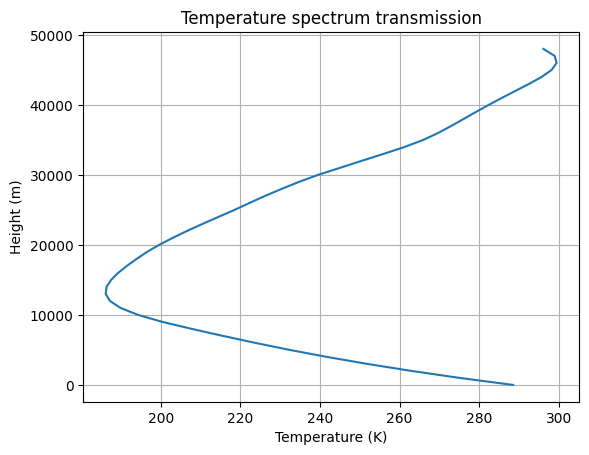

[[-1.          0.56875973  0.04170714  0.01815228  0.00963568]
 [ 0.56611532 -1.13752116  0.4895375   0.0233139   0.00824047]
 [ 0.04194165  0.48398583 -1.06249055  0.44795716  0.02246743]
 [ 0.01858364  0.0231587   0.44230498 -0.9788476   0.40293584]
 [ 0.01013303  0.0082459   0.02229318  0.39727144 -0.88655945]] First 4x4
288.5676061359832


In [623]:
###AUTOMatic


def N_layer_system_dif_t1(Eps,c_dif): #Eps[0]=1 to work properly
    
    N=len(Eps)
    ones=np.ones_like(Eps)
    t=ones-Eps
    accuracy=1e-7
    # Epsilon cant be 1 or 0, singular matrix otherwise 
    for i in range(len(Eps)-1):
        for j in range(len(Eps)-1):
            if (Eps[i+1,j+1]<=accuracy):
                Eps[i+1,j+1]=accuracy
            elif (Eps[i+1,j+1]>=1-accuracy):
                Eps[i+1,j+1]=1-accuracy
            
    M=np.zeros_like(Eps,dtype=np.float64)
    #Only put in transmissions of lates in EPS
    
    for i in range(N): #number of rows
        for j in range(N): #making the columns.
            #Under diagonal   
            if i == 0 and j == 0:
                M[i,j]=(-1)*Eps[i,j]
            
            elif j == i and i!=0:
                M[i,j]=(-2)*Eps[i,j]  
            
            else:
                M[i,j]=Eps[i,j] 
             
                
    #Convection
    for i in range(N-1):#Add convective coefficients
        M[i,i]=M[i,i]-c_dif[i]
        M[i+1,i]=M[i+1,i]+c_dif[i]       
    return M
c_dif=c*0

### Make epsilon_grey differnt for corelation of spectal overlap


def spectrum_model_grey_diff(eps_spec,tau_5_spec,mid_Treal_t,Band_interval):
    eps_grey_dif=np.ones([len(T_real),len(T_real)],dtype=np.float64)#make 64 bit
    #eps_grey_dif[0,:]=np.ones(len(T_real))
    eps_weight_own=np.zeros_like(eps_spec,dtype=np.float64)
    eps_weight_own[0,:]=planck_spec(mid_Treal_t[0],Band_interval)/np.sum(planck_spec(mid_Treal_t[0],Band_interval))
    for i in range(1,len(T_real)): #Fill rows with weighted epsilons. How well does it absorb energi at a temperature
        eps_weight_own[i,:]=(eps_spec[i]*planck_spec(mid_Treal_t[i],Band_interval))/np.sum(planck_spec(mid_Treal_t[i],Band_interval)) #Emitted spectrum energi ratio released
        

    eps_grey_dif=np.ones_like(eps_grey_dif,dtype=np.float64)

    tau_5_spect=np.vstack([np.ones_like(eps_spec[0,:])*1000000,tau_5_spec]) #Surface tau very high all absorbed

    for trans in range(len(T_real)): #True len(T_real)-1
        for i in range(len(T_real)): # Loop over layers
            for j in range(len(T_real)):# Loop over combinations
                if trans==0:
                    if i==j:
                        eps_grey_dif[i,j]=eps_to_grey(tau_5_spect[i],planck_spec(mid_Treal_t[i],Band_interval),Band_interval) #regular grey
                if trans==1 :
                    if j-i==1:
                        eps_grey_dif[i,j]=np.sum(eps_spec[i,:]*eps_weight_own[j,:]) #ROW is absorbed ratio for emitting layer j 
                    if i-j==1:
                        eps_grey_dif[i,j]=np.sum(eps_spec[i,:]*eps_weight_own[j,:])
                    
                if trans>1:    
                    if j-i==trans and j>=trans:
                        spec_remain=np.zeros([trans,len(eps_spec[0,:])])
                        spec_abs=np.zeros([trans,len(eps_spec[0,:])])
                        for t in range(trans):
                            if t==0:
                                spec_abs[t]=eps_spec[i+trans-1,:]*eps_weight_own[j,:]
                                #eps_grey_dif[i,j]=np.sum(spec_abs[t])
                                spec_remain[t]=eps_weight_own[j,:]-spec_abs[t]
                            if t>0:
                                spec_abs[t]=spec_remain[t-1]*eps_spec[i+trans-t-1,:]
                                spec_remain[t]=eps_weight_own[j,:]-np.sum(spec_abs,axis=0)
                                if t==trans-1:#last
                                    eps_grey_dif[i,j]=np.sum(spec_abs[t,:])
                    
                    if i-j==trans and i>=trans :
                        spec_remain=np.zeros([trans,len(eps_spec[0,:])])
                        spec_abs=np.zeros([trans,len(eps_spec[0,:])])
                        for t in range(trans):
                            if t==0:
                                spec_abs[t]=eps_spec[i-trans+1,:]*eps_weight_own[j,:]
                                #eps_grey_dif[i,j]=np.sum(spec_abs[t])
                                spec_remain[t]=eps_weight_own[j,:]-spec_abs[t]
                            if t>0:
                                spec_abs[t]=spec_remain[t-1]*eps_spec[i-trans+t+1,:]
                                spec_remain[t]=eps_weight_own[j,:]-np.sum(spec_abs,axis=0)
                                if t==trans-1:#last
                                    eps_grey_dif[i,j]=np.sum(spec_abs[t,:])
    return eps_grey_dif
eps_grey_dif=spectrum_model_grey_diff(eps_spec,tau_5_spec,mid_Treal_t,Band_interval)
                    
            
                                            

M_dif_t=N_layer_system_dif_t1(eps_grey_dif,c_dif)
E_test=np.zeros(len(z_interp))
E_test[0]=240
Q_dif,T_dif=solve_fit_atmosphere(-E_in_SW_US,M_dif_t)
plt.plot(T_dif[0:49],z_interp[0:49],label='Grey model temp differnt eps')
plt.xlabel('Temperature (K)')
plt.ylabel('Height (m)')
plt.title('Temperature spectrum transmission')
#plt.xlim(150,290)
plt.grid()
plt.show()


#Try to fix with Convective coefficents
#T_con_dif,c_dif,time_dif=convective_adjustment(eps_grey_dif,Gamma=7,E_in_SW_tot=E_test,stepscale=0.02,system=N_layer_system_dif)
#plt.plot(T_con_dif[:16],z_interp[:16],label='With convection dif eps')



#print(eps_grey_dif[0:5,0:5])


print(M_dif_t[0:5,0:5],"First 4x4")


print(T_dif[0])

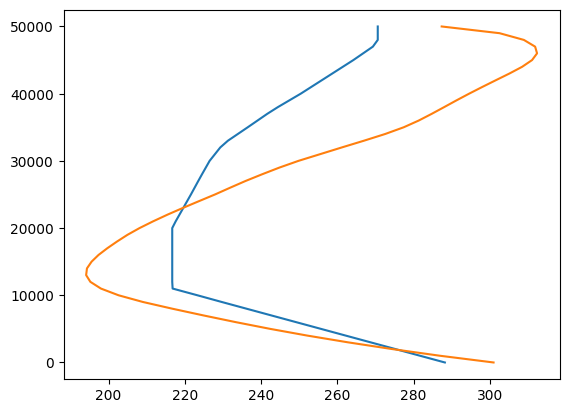

In [624]:
c_dif=np.zeros(len(T_real))
M_dif_t=N_layer_system_dif_t1(eps_grey_dif,c_dif)
E_test=np.zeros(len(z_interp))
E_test[0]=240
Q_dif_us,T_dif_us=solve_fit_atmosphere(-E_in_SW_US*284/240,M_dif_t)
plt.plot(T_real,z_interp)
plt.plot(T_dif_us,z_interp)
plt.show()
T_dif_con_us,c_us,time_us,M_con_us=convective_adjustment(eps_grey=eps_grey_dif,Gamma=np.ones(len(eps_grey_dif)-1)*6.5,E_in_SW_tot=E_in_SW_US,stepscale=0.001,system=N_layer_system_dif_t1)

[6.49988635 6.497766   6.49958593 6.49492244 6.49114192 6.49010203
 6.49105339 6.49428196 6.49953355 6.49330577]
[289.1660039  282.66611755 276.16835154 269.66876561 263.17384317
 256.68270125 250.19259922 243.70154584 237.20726388 230.70773032]
[ -0.9660039   -0.96611755  -0.96835154  -0.96876561  -0.97384317
  -0.98270125  -0.99259922  -1.00154584  -1.00726388  -1.00773032
  -0.91442455  -0.93868276   5.45887906   9.72234058  11.66674279
  12.11718888  11.63933718  10.45927922   8.85261435   6.9131406
   4.45125318   2.39513668   0.10189968  -2.51135259  -5.33578501
  -8.25949672 -10.99420836 -13.84975274 -17.0412065  -20.42077261
 -24.27824372 -28.44658411 -32.6271823  -36.3353277  -39.2352376
 -41.44151908 -42.76058169 -43.56959557 -44.00958126 -44.19580686
 -44.49001563 -45.15815847 -45.91598837 -46.71211156 -47.26167831
 -47.08443647 -45.81674896 -42.73673349 -38.49411445 -32.10812905
 -16.90023248]


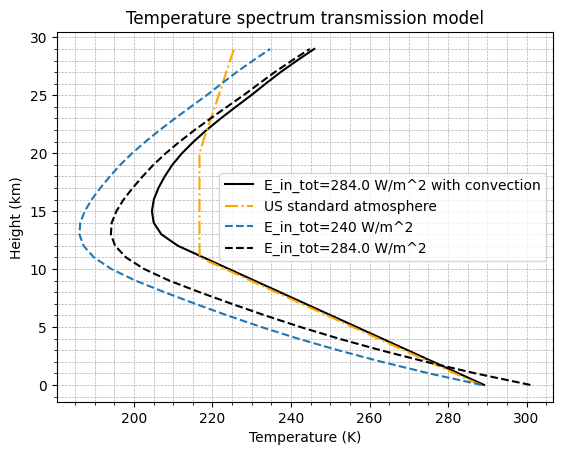

In [628]:
#Make beatifull plot with many thin grid lines

plt.plot(T_dif_con_us[:30],z_interp[:30]/1000,color="black",label='E_in_tot=284.0 W/m^2 with convection')
plt.plot(T_real[:30],z_interp[:30]/1000,label='US standard atmosphere',linestyle="dashdot",color="orange")
plt.plot(T_dif[:30],z_interp[:30]/1000,label='E_in_tot=240 W/m^2', linestyle="--")
plt.plot(T_dif_us[:30],z_interp[:30]/1000,color="black",label='E_in_tot=284.0 W/m^2',linestyle="--")
plt.xlabel('Temperature (K)')
plt.ylabel('Height (km)')
plt.title('Temperature spectrum transmission model')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()


print(T_dif_con_us[0:10]-T_dif_con_us[1:11])

#print(c)
print(T_dif_con_us[0:10])
print(T_real-T_dif_con_us)




In [ ]:
"""
#US standard atmosphere fit with  CO2 doubling  #equilibrium temp at 284.0 W/m2 input
#T_real, mid_Treal,mid_Treal_t, mid_preal, n_CO2_mid, n_H2O_mid, n_03_mid, n_N2O_mid, n_CH4_mid,z_interp, dz=initialize_atmosphere(file="Standard_Atmospheres/us_standard.csv",height=50,dz=1000,CO2PPM=400)
#US_CO2_eps,US_CO2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, n_CO2_mid,n_H2O_mid,n_N2O_mid,n_CH4_mid,n_03_mid, dz)
US_CO2X2_eps,US_CO2X2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, n_CO2_mid*2,n_H2O_mid,n_N2O_mid,n_CH4_mid,n_03_mid, dz)
#model_eps=model_spectrum_grey_diff(US_CO2_eps,US_CO2_tau,mid_Treal_t,Band_interval)
model_eps_X2=spectrum_model_grey_diff(US_CO2X2_eps,US_CO2X2_tau,mid_Treal_t,Band_interval)
#M_us=N_layer_system_dif_t1(model_eps,c_dif)
M_us_X2=N_layer_system_dif_t1(model_eps_X2,c_dif)
Q_us_X2,T_us_X2=solve_fit_atmosphere(-E_in_SW_US*284/240,M_us_X2)


#Midlatitude summer (45 deg lat) RM flux TOA 312.5849 W/m^2
S45_Treal, S45_mid_Treal,S45_mid_Treal_t, S45_mid_preal, S45_n_CO2_mid, S45_n_H2O_mid, S45_n_03_mid, S45_n_N2O_mid, S45_n_CH4_mid,S45_z_interp, S45_dz=initialize_atmosphere(file="Standard_Atmospheres/mid_lat_summer.csv",height=50,dz=1000,CO2PPM=400)
S45_CO2_eps,S45_CO2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, S45_n_CO2_mid,S45_n_H2O_mid,S45_n_N2O_mid,S45_n_CH4_mid,S45_n_03_mid, S45_dz)
S45_CO2X2_eps,S45_CO2X2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, S45_n_CO2_mid*2,S45_n_H2O_mid,S45_n_N2O_mid,S45_n_CH4_mid,S45_n_03_mid, S45_dz)
S45_model_eps=spectrum_model_grey_diff(S45_CO2_eps,S45_CO2_tau,S45_mid_Treal_t,Band_interval)
S45_model_eps_X2=spectrum_model_grey_diff(S45_CO2X2_eps,S45_CO2X2_tau,S45_mid_Treal_t,Band_interval)
M_S45=N_layer_system_dif_t1(S45_model_eps,c_dif)
M_S45_X2=N_layer_system_dif_t1(S45_model_eps_X2,c_dif)
Q_S45,T_S45=solve_fit_atmosphere(-E_in_SW_S45*312.5849/240,M_S45)
Q_S45_X2,T_S45_X2=solve_fit_atmosphere(-E_in_SW_S45*312.5849/240,M_S45_X2)

print("first done")

#Midlatitude winter (45 deg lat) RM flux TOA 243.6813 W/m^2
W45_Treal, W45_mid_Treal,W45_mid_Treal_t, W45_mid_preal, W45_n_CO2_mid, W45_n_H2O_mid, W45_n_03_mid, W45_n_N2O_mid, W45_n_CH4_mid,W45_z_interp, W45_dz=initialize_atmosphere(file="Standard_Atmospheres/mid_lat_winter.csv",height=50,dz=1000,CO2PPM=400)
W45_CO2_eps,W45_CO2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, W45_n_CO2_mid,W45_n_H2O_mid,W45_n_N2O_mid,W45_n_CH4_mid,W45_n_03_mid, W45_dz)
W45_CO2X2_eps,W45_CO2X2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, W45_n_CO2_mid*2,W45_n_H2O_mid,W45_n_N2O_mid,W45_n_CH4_mid,W45_n_03_mid, W45_dz)
W45_model_eps=spectrum_model_grey_diff(W45_CO2_eps,W45_CO2_tau,W45_mid_Treal_t,Band_interval)
W45_model_eps_X2=spectrum_model_grey_diff(W45_CO2X2_eps,W45_CO2X2_tau,W45_mid_Treal_t,Band_interval)
M_W45=N_layer_system_dif_t1(W45_model_eps,c_dif)
M_W45_X2=N_layer_system_dif_t1(W45_model_eps_X2,c_dif)
Q_W45,T_W45=solve_fit_atmosphere(-E_in_SW_W45*243.6813/240,M_W45)
Q_W45_X2,T_W45_X2=solve_fit_atmosphere(-E_in_SW_W45*243.6813/240,M_W45_X2)

print("second done")
#Subpolar Summer 60 dag lat RM flux TOA 220.7012 W/m^2
S60_Treal, S60_mid_Treal,S60_mid_Treal_t, S60_mid_preal, S60_n_CO2_mid, S60_n_H2O_mid, S60_n_03_mid, S60_n_N2O_mid, S60_n_CH4_mid,S60_z_interp, S60_dz=initialize_atmosphere(file="Standard_Atmospheres/sub_polar_summer.csv",height=50,dz=1000,CO2PPM=400)
S60_CO2_eps,S60_CO2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, S60_n_CO2_mid,S60_n_H2O_mid,S60_n_N2O_mid,S60_n_CH4_mid,S60_n_03_mid, S60_dz)
S60_CO2X2_eps,S60_CO2X2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, S60_n_CO2_mid*2,S60_n_H2O_mid,S60_n_N2O_mid,S60_n_CH4_mid,S60_n_03_mid, S60_dz)
S60_model_eps=spectrum_model_grey_diff(S60_CO2_eps,S60_CO2_tau,S60_mid_Treal_t,Band_interval)
S60_model_eps_X2=spectrum_model_grey_diff(S60_CO2X2_eps,S60_CO2X2_tau,S60_mid_Treal_t,Band_interval)
M_S60=N_layer_system_dif_t1(S60_model_eps,c_dif)
M_S60_X2=N_layer_system_dif_t1(S60_model_eps_X2,c_dif)
Q_S60,T_S60=solve_fit_atmosphere(-E_in_SW_S60*220.7012/240,M_S60)
Q_S60_X2,T_S60_X2=solve_fit_atmosphere(-E_in_SW_S60*220.7012/240,M_S60_X2)

#Subpolar Winter 60 dag lat RM flux TOA 169.6183 W/m^2
W60_Treal, W60_mid_Treal,W60_mid_Treal_t, W60_mid_preal, W60_n_CO2_mid, W60_n_H2O_mid, W60_n_03_mid, W60_n_N2O_mid, W60_n_CH4_mid,W60_z_interp, W60_dz=initialize_atmosphere(file="Standard_Atmospheres/sub_polar_winter.csv",height=50,dz=1000,CO2PPM=400)
W60_CO2_eps,W60_CO2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, W60_n_CO2_mid,W60_n_H2O_mid,W60_n_N2O_mid,W60_n_CH4_mid,W60_n_03_mid, W60_dz)
W60_CO2X2_eps,W60_CO2X2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, W60_n_CO2_mid*2,W60_n_H2O_mid,W60_n_N2O_mid,W60_n_CH4_mid,W60_n_03_mid, W60_dz)
W60_model_eps=spectrum_model_grey_diff(W60_CO2_eps,W60_CO2_tau,W60_mid_Treal_t,Band_interval)
W60_model_eps_X2=spectrum_model_grey_diff(W60_CO2X2_eps,W60_CO2X2_tau,W60_mid_Treal_t,Band_interval)
M_W60=N_layer_system_dif_t1(W60_model_eps,c_dif)
M_W60_X2=N_layer_system_dif_t1(W60_model_eps_X2,c_dif)  
Q_W60,T_W60=solve_fit_atmosphere(-E_in_SW_W60*169.6183/240,M_W60)
Q_W60_X2,T_W60_X2=solve_fit_atmosphere(-E_in_SW_W60*169.6183/240,M_W60_X2)

"""
#Tropical 15 deg lat RM flux TOA 311.7062 W/m^2
T15_Treal, T15_mid_Treal,T15_mid_Treal_t, T15_mid_preal, T15_n_CO2_mid, T15_n_H2O_mid, T15_n_03_mid, T15_n_N2O_mid, T15_n_CH4_mid,T15_z_interp, T15_dz=initialize_atmosphere(file="Standard_Atmospheres/tropical.csv",height=50,dz=1000,CO2PPM=400)
T15_CO2_eps,T15_CO2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, T15_n_CO2_mid,T15_n_H2O_mid,T15_n_N2O_mid,T15_n_CH4_mid,T15_n_03_mid, T15_dz)
T15_CO2X2_eps,T15_CO2X2_tau=spectrum_to_eps_combined(CO2_spectrum,H2O_spectrum,O3_spectrum,N2O_spectrum,CH4_spectrum, T15_n_CO2_mid*2,T15_n_H2O_mid,T15_n_N2O_mid,T15_n_CH4_mid,T15_n_03_mid, T15_dz)
T15_model_eps=spectrum_model_grey_diff(T15_CO2_eps,T15_CO2_tau,T15_mid_Treal_t,Band_interval)
T15_model_eps_X2=spectrum_model_grey_diff(T15_CO2X2_eps,T15_CO2X2_tau,T15_mid_Treal_t,Band_interval)    
M_T15=N_layer_system_dif_t1(T15_model_eps,c_dif)
M_T15_X2=N_layer_system_dif_t1(T15_model_eps_X2,c_dif)
Q_T15,T_T15=solve_fit_atmosphere(-E_in_SW_15N*311.7062/240,M_T15)
Q_T15_X2,T_T15_X2=solve_fit_atmosphere(-E_in_SW_15N*311.7062/240,M_T15_X2)


In [ ]:
###Make convection. Scaled by RM TOA FLux.
T_dif_con_us,c_us,time_us,M_con_us=convective_adjustment(eps_grey=eps_grey_dif,Gamma=np.ones(len(eps_grey_dif)-1)*6.5,E_in_SW_tot=E_in_SW_US*284/240,stepscale=0.001,system=N_layer_system_dif_t1)
T_us_X2_con,c_us_X2,time_us_X2,M_con_us_X2=convective_adjustment(eps_grey=model_eps_X2,Gamma=np.ones(len(model_eps_X2)-1)*6.5,E_in_SW_tot=E_in_SW_US*284/240,stepscale=0.001,system=N_layer_system_dif_t1)
S45_T_con,c_S45,time_S45=convective_adjustment(eps_grey=S45_model_eps,Gamma=6.5,E_in_SW_tot=E_in_SW_S45*312.5849/240,stepscale=0.001,system=N_layer_system_dif_t1)
S45_T_con_X2,c_S45_X2,time_S45_X2=convective_adjustment(eps_grey=S45_model_eps_X2,Gamma=6.5,E_in_SW_tot=E_in_SW_S45*312.5849/240,stepscale=0.001,system=N_layer_system_dif_t1)
W45_T_con,c_W45,time_W45=convective_adjustment(eps_grey=W45_model_eps,Gamma=6.5,E_in_SW_tot=E_in_SW_W45*243.6813/240,stepscale=0.001,system=N_layer_system_dif_t1)
W45_T_con_X2,c_W45_X2,time_W45_X2=convective_adjustment(eps_grey=W45_model_eps_X2,Gamma=6.5,E_in_SW_tot=E_in_SW_W45*243.6813/240,stepscale=0.001,system=N_layer_system_dif_t1)
S60_T_con,c_S60,time_S60=convective_adjustment(eps_grey=S60_model_eps,Gamma=6.5,E_in_SW_tot=E_in_SW_S60*220.7012/240,stepscale=0.001,system=N_layer_system_dif_t1)
S60_T_con_X2,c_S60_X2,time_S60_X2=convective_adjustment(eps_grey=S60_model_eps_X2,Gamma=6.5,E_in_SW_tot=E_in_SW_S60*220.7012/240,stepscale=0.001,system=N_layer_system_dif_t1)
W60_T_con,c_W60,time_W60=convective_adjustment(eps_grey=W60_model_eps,Gamma=6.5,E_in_SW_tot=E_in_SW_W60*169.6183/240,stepscale=0.001,system=N_layer_system_dif_t1)
W60_T_con_X2,c_W60_X2,time_W60_X2=convective_adjustment(eps_grey=W60_model_eps_X2,Gamma=6.5,E_in_SW_tot=E_in_SW_W60*169.6183/240,stepscale=0.001,system=N_layer_system_dif_t1)
T15_T_con,c_S45,time_S45=convective_adjustment(eps_grey=S45_model_eps,Gamma=6.5,E_in_SW_tot=E_in_SW_15N*312.5849/240,stepscale=0.001,system=N_layer_system_dif_t1)
T15_T_con_X2,c_S45_X2,time_S45_X2=convective_adjustment(eps_grey=S45_model_eps_X2,Gamma=6.5,E_in_SW_tot=E_in_SW_15N*312.5849/240,stepscale=0.001,system=N_layer_system_dif_t1)


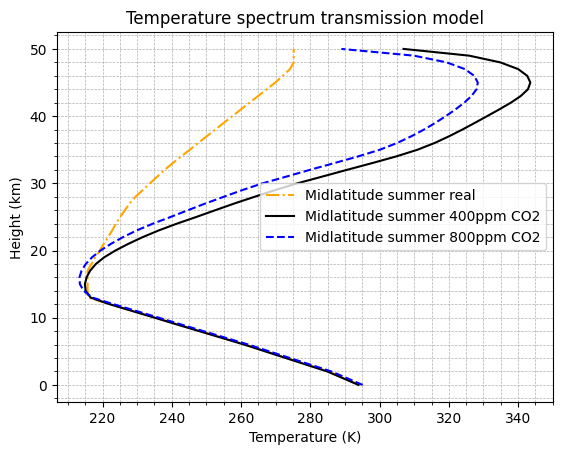

In [631]:

#plt.plot(T_dif_con_us[:30],z_interp[:30]/1000,color="black",label='E_in_tot=284.0 W/m^2 with convection')
#plt.plot(T_us_X2_con[:30],z_interp[:30]/1000,color="red",label='US standard atmosphere 800ppm CO2 with convection')
#plt.plot(T_real[:30],z_interp[:30]/1000,label='US standard atmosphere',linestyle="dashdot",color="orange")
#In the top it only changes more no new trend above 30 km.
#print(T_us_X2_con-T_dif_con_us)

#Gamma has to stop at tropopause ~11 km. Find index of biggest accerlation in Treal, that is tropopause
S45_gamma_all=S45_Treal[:-1]-S45_Treal[1:]
tropopause_index= np.argmax(S45_gamma_all[:-1]-S45_gamma_all[:-1])#Largest accerlation in lapse rate

S45_Gamma=S45_gamma_all[:tropopause_index-1]
S45_Gamma=np.concatenate((S45_Gamma,np.ones(len(S45_Treal)-1-len(S45_Gamma))*10)) #10 K lapse rate above start of tropopause.
#S45_T_con,S45_c,S45_time,S45_M_con=convective_adjustment(eps_grey=S45_model_eps,Gamma=S45_Gamma,E_in_SW_tot=E_in_SW_S45*312.5849/240,stepscale=0.001,system=N_layer_system_dif_t1)
#S45_T_con_X2,S45_c_X2,S45_time_X2,S45_M_con_X2=convective_adjustment(eps_grey=S45_model_eps_X2,Gamma=S45_Gamma,E_in_SW_tot=E_in_SW_S45*312.5849/240,stepscale=0.001,system=N_layer_system_dif_t1)

plt.plot(S45_Treal[:],S45_z_interp[:]/1000,label='Midlatitude summer real',linestyle="dashdot",color="orange")
plt.plot(S45_T_con[:],S45_z_interp[:]/1000,color="black",label='Midlatitude summer 400ppm CO2')
plt.plot(S45_T_con_X2[:],S45_z_interp[:]/1000,color="blue",label='Midlatitude summer 800ppm CO2',linestyle="--")
plt.xlabel('Temperature (K)')
plt.ylabel('Height (km)')
plt.title('Temperature spectrum transmission model')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()

#calc rm top mid_summer
#Fd_tot,Fup_tot,Fd,Fup = RM_flux_calculation(S45_CO2_tau,S45_mid_Treal_t,Band_interval)
#print(Fup_tot[-2])

In [632]:
print(S45_Treal-S45_T_con)
print(S45_T_con-S45_T_con_X2)


[  0.2830315    0.27819399   0.27663599   0.27535005   0.27370391
   0.26719627   0.25923266   0.25444767   0.24829721   0.23889145
   0.23539438   0.22854018   0.19311556  -0.76707334   0.56958186
   0.78250784   0.30098222  -0.72229172  -1.28866701  -2.61774767
  -4.52073256  -7.07198355 -10.02853359 -13.4821148  -17.58782517
 -22.01756204 -26.10090441 -30.25258536 -34.38757252 -38.26245628
 -42.57295211 -47.61179521 -52.61112568 -57.55365694 -62.07312594
 -65.75185417 -68.25301137 -69.98128272 -71.36463958 -72.50323837
 -73.55707444 -74.58691994 -75.45015788 -75.84887002 -75.4245359
 -73.63929739 -70.614766   -65.87567492 -59.63674807 -50.65645595
 -31.71965009]
[-1.19859731 -1.19398058 -1.19343103 -1.1955775  -1.20019008 -1.19525699
 -1.19509591 -1.2038537  -1.20686002 -1.19831283 -1.19624225 -1.19836793
 -1.17503077 -0.48630447  0.57066384  1.4507887   2.05760086  2.47732037
  2.91525846  3.52433752  4.28466196  5.01511409  5.69719036  6.37128856
  6.93402896  7.41657511  7.897504

8.013767408425673
15.59877221474284


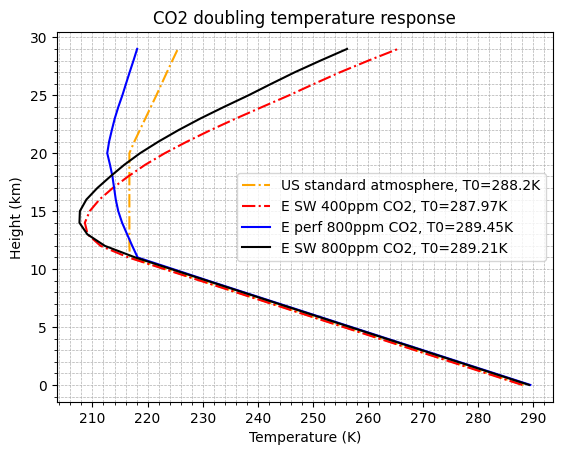

[  1.24638149   1.24734745   1.24391506   1.24887281   1.24238264
   1.24268214   1.24915976   1.2532945    1.25513948   1.26944792
   1.30021231   1.39810522   0.52058622  -0.40989166  -1.32236305
  -2.01825217  -2.46928503  -2.77295446  -3.07682097  -3.5157431
  -4.01929889  -4.5780764   -5.08289952  -5.55133063  -5.90047581
  -6.16947173  -6.47214852  -6.76421467  -7.05310021  -7.39420931
  -7.68728526  -7.77432868  -7.87326939  -7.94323449  -7.89093433
  -7.74301449  -7.71628156  -7.77562321  -7.95852232  -8.29383219
  -8.7755611   -9.35064824  -9.99781505 -10.63124182 -11.15451317
 -11.53759116 -11.80266446 -12.15425115 -12.53191523 -13.41918324
 -17.33915127]
[  1.24283229   1.24342329   1.23964971   1.24413558   1.23678881
   1.23593587   1.24063306   1.24159888   1.23818579   1.24295626
   1.25960459   1.24174019   0.77291341  -0.04871209  -0.98309187
  -1.78699277  -2.36753378  -2.80150764  -3.233036    -3.79505405
  -4.48883329  -5.16870573  -5.81755361  -6.45176871  -6.95633

In [ ]:
#Perfect energy input E fit
#US standard atmosphere fit with  CO2 doubling  #equilibrium temp at 284.0 W/m2 input
sigma = 5.670374419e-8
E_perf=(M_con_us*sigma)@T_real**4
#differnce
#energy input
E_difference=E_perf+E_in_SW_US*284/240
#print(E_difference)
print(np.sum(E_difference[20:]))
print(np.sum(E_in_SW_US[20:]*284/240))


Q_perf_us,T_perf_us=solve_fit_atmosphere(E_perf,M_con_us)
Q_perf_us_X2,T_perf_us_X2=solve_fit_atmosphere(E_perf,M_con_us_X2)
#Convective adjust of X2
#T_perf_us_X2_con,c_us_X2_con,time_us_X2_con,M_us_X2_con=convective_adjustment(eps_grey=model_eps_X2,Gamma=np.ones(len(model_eps_X2)-1)*6.5,E_in_SW_tot=E_perf,stepscale=0.001,system=N_layer_system_dif_t1)

#Write string with 2 decimal places
plt.plot(T_perf_us[:30],z_interp[:30]/1000,label='US standard atmosphere, T0='+str(np.round(T_perf_us[0],2))+'K',linestyle="dashdot",color="orange")
plt.plot(T_dif_con_us[:30],z_interp[:30]/1000,label='E SW 400ppm CO2, T0='+str(np.round(T_dif_con_us[0],2))+'K',color="red",linestyle="dashdot")
plt.plot(T_perf_us_X2[:30],z_interp[:30]/1000,label='E perf 800ppm CO2, T0='+str(np.round(T_perf_us_X2[0],2))+'K',color="blue")
plt.plot(T_us_X2_con[:30],z_interp[:30]/1000,label='E SW 800ppm CO2, T0='+str(np.round(T_us_X2_con[0],2))+'K',color="black")

plt.xlabel('Temperature (K)')
plt.ylabel('Height (km)')
plt.title('CO2 doubling temperature response')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.show()


#plt.plot(T_perf_us_X2_con,z_interp,label='Grey model temp 800ppm CO2 with convection')
print(T_perf_us_X2-T_perf_us)
print(T_us_X2_con-T_dif_con_us)
#print(T_perf_us_X2[:10]-T_perf_us_X2_con[:10])
#print(c_us_X2_con[:10])

In [ ]:
#Find TOA equilibrium fluxes
Fd_tot_perf_us,Fup_tot_perf_us,Fd_perf_us,Fup_perf_us = RM_flux_calculation(tau,mid_Treal_t,Band_interval)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


Flux calculation

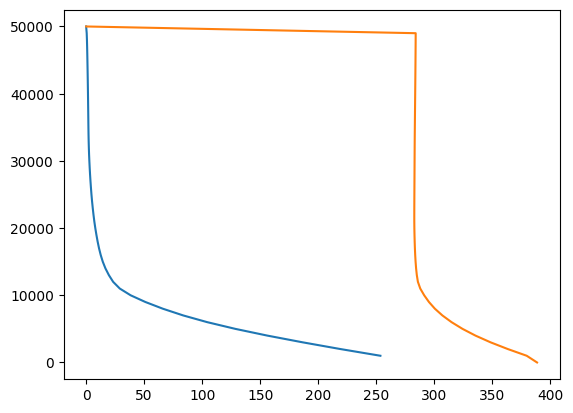

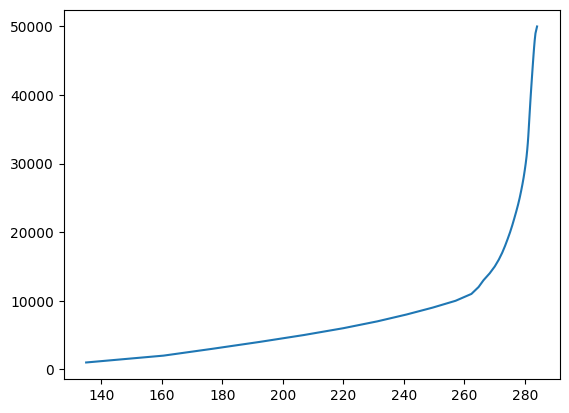

0.0 283.98093232072875
253.55980054157774 388.55852245222445


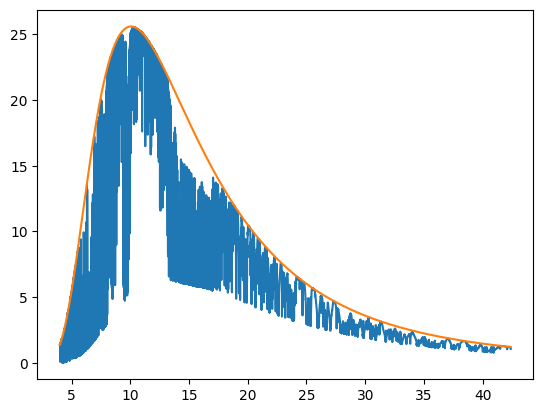

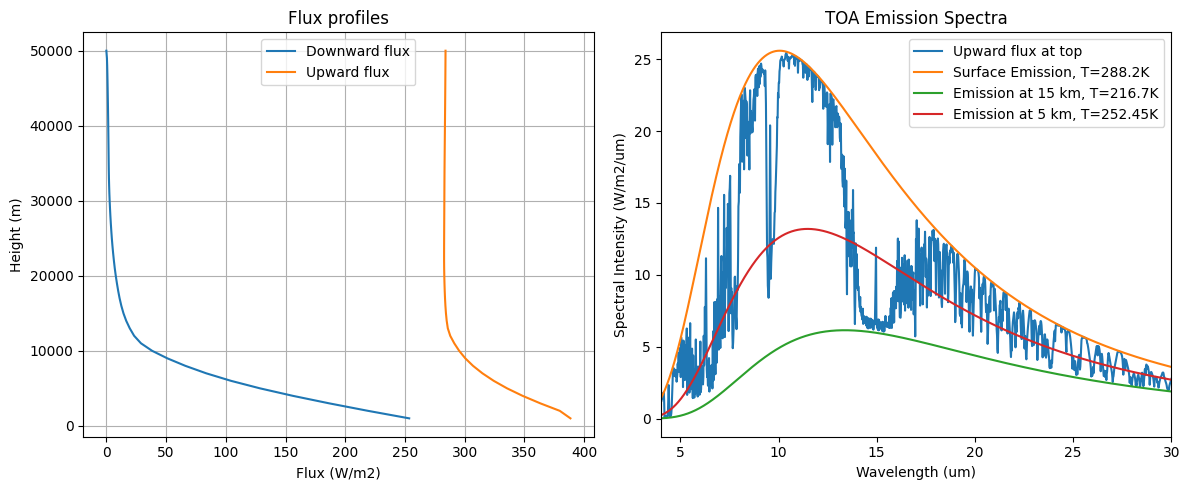

[288.2  284.95 278.45 271.95 265.45 258.95 252.45 245.95 239.45 232.95
 226.5  220.05 216.75 216.7  216.7  216.7  216.7  216.7  216.7  216.7
 216.7  217.15 218.1  219.1  220.1  221.1  222.08 223.04 224.01 225.
 226.   227.2  228.6  230.3  232.6  235.2  237.78 240.34 243.01 245.9
 248.9  251.78 254.54 257.3  260.06 262.82 265.48 268.04 269.96 270.6
 270.6 ]


In [633]:

#Calc fluxes via optical depth method


#replace tau<0 with 0
def RM_flux_calculation(tau_5_spec,mid_Treal_t,Band_interval):
    tau_d=tau_5_spec#Up to down

    Fd=np.zeros(tau_d.shape)

    mu=1/np.sqrt(3)#cos(theta) to zentith angle. Ekstra distance
    
    for i in range(len(Fd)-1): #First downward flux=0. I from 1 to len(Fd)
        B_power=black_body_spectrum(mid_Treal_t[-i-2],Band_interval)
        Fd[i+1,:]=Fd[i,:]*np.exp(-tau_d[-i-2]/mu)+B_power*(1-np.exp(-tau_d[-i-2]/mu)) #
        
    #Take sum of each layer and plot 
    Fd_tot=[]
    for i in range(len(Fd)):
        Fd_tot.append(np.sum(Fd[i]))
    Fd_tot=Fd_tot[::-1] #Turn down to up
    Fd_tot=np.array(Fd_tot)



    ### Upward flux

    tau_up=np.vstack([tau_5_spec,np.zeros(len(tau_5_spec[0]))])
    Fup=np.zeros(tau_up.shape)
    B_power=black_body_spectrum(mid_Treal_t[0],Band_interval)
    Fup[0,:]=B_power
    for i in range(1,len(Fd)): #First downward flux=0. I from 1 to len(Fd)
        B_power=black_body_spectrum(mid_Treal_t[i],Band_interval)
        Fup[i,:] = Fup[i-1,:]*np.exp(-tau_up[i]/mu) + B_power*(1 - np.exp(-tau_up[i]/mu))
    Fup_tot=[]

    for i in range(len(Fup[:,0])):
        Fup_tot.append(np.sum(Fup[i]))
    Fup_tot=np.array(Fup_tot)
    return Fd_tot,Fup_tot,Fd,Fup
Fd_tot,Fup_tot,Fd,Fup = RM_flux_calculation(tau_5_spec,mid_Treal_t,Band_interval)
plt.plot(Fd_tot,z_interp[1:])
plt.plot(Fup_tot,z_interp)
plt.show()



plt.plot(Fup_tot[:-1]-Fd_tot,z_interp[1:])
plt.show()
print(Fd_tot[-1],Fup_tot[-2])
print(Fd_tot[0],Fup_tot[0])

#Emission spectrum at top
plt.plot(Band_interval[:40000],Fup[-2,:40000]*1/(Band_interval[1]-Band_interval[0]))
plt.plot(Band_interval[:40000],planck_spec(mid_Treal_t[0],Band_interval[:40000]))
plt.show()

#make 2 plots togehter of flux tot up and downward and emission spectra at top

F_up_mean=np.zeros(int(len(Band_interval)//20))
for i in range(int(len(Band_interval)//20)):
    F_up_mean[i]=np.mean(Fup[-2,i*20:(i+1)*20])
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(Fd_tot,z_interp[1:],label='Downward flux')
ax1.plot(Fup_tot[:-1],z_interp[1:],label='Upward flux')
ax1.set_xlabel('Flux (W/m2)')
ax1.set_ylabel('Height (m)')
ax1.set_title('Flux profiles')
ax1.grid()
ax1.legend()

ax2.plot(Band_interval[::20],F_up_mean*(1/(Band_interval[1]-Band_interval[0])),label='Upward flux at top')
ax2.plot(Band_interval,black_body_spectrum(mid_Treal_t[0],Band_interval)*(1/(Band_interval[1]-Band_interval[0])),label='Surface Emission, T='+str(mid_Treal_t[0])+'K')
ax2.plot(Band_interval,black_body_spectrum(np.min(mid_Treal_t),Band_interval)*(1/(Band_interval[1]-Band_interval[0])),label='Emission at 15 km, T='+str(np.min(mid_Treal_t))+'K')
ax2.plot(Band_interval,black_body_spectrum(mid_Treal_t[6],Band_interval)*(1/(Band_interval[1]-Band_interval[0])),label='Emission at 5 km, T='+str(mid_Treal_t[6])+'K')
ax2.set_title('TOA Emission Spectra')
ax2.set_xlabel('Wavelength (um)')
ax2.set_ylabel('Spectral Intensity (W/m2/um)')
ax2.set_xlim(4,30)
ax2.legend()
plt.tight_layout()
plt.show()


print(mid_Treal_t)

In [ ]:
# ... same data loading as before ...
z,O, T,p, n_air, h2o = read_atmosphere("Standard_Atmospheres/us_standard.csv",50,1000)
z1,O1, T1,p1, n_air1, h2o1 = read_atmosphere("Standard_Atmospheres/tropical.csv",50,1000)

fig, ax1 = plt.subplots(figsize=(9, 6))

# --- Temperature (base axis) ---
l1, = ax1.plot(T, z/1000.0,  color='tab:red', lw=2, label='T (US Std)')
l2, = ax1.plot(T1, z1/1000.0, '--', color='tab:red', lw=2, label='T (MidLat Summer)')
ax1.set_xlabel('Temperature [K]', color='tab:red')
ax1.set_ylabel('Altitude [km]')
ax1.tick_params(axis='x', colors='tab:red')
ax1.set_xlim(200, 300)
ax1.set_ylim(0, 50)
ax1.grid(True, linestyle='--', alpha=0.4)

# Make the base axis patch transparent so it doesn't cover other axes
ax1.patch.set_alpha(0.0)

# --- Pressure (twinned, on top) ---
ax2 = ax1.twiny()
# If your p is in hPa, multiply by 100; if already Pa, leave as-is.
p_pa  = p 
p_pa1 = p1 

l3, = ax2.plot(p_pa,  z/1000.0,  color='tab:blue',  lw=2, label='p (US Std)', zorder=5)
l4, = ax2.plot(p_pa1, z1/1000.0, '--', color='tab:blue',  lw=2, label='p (MidLat Summer)', zorder=5)
ax2.set_xlabel('Pressure [Pa]', color='tab:blue')
ax2.tick_params(axis='x', colors='tab:blue')
ax2.set_xscale('log')
ax2.set_xlim(0, 1.01325e5)  # very narrow: will show a tiny segment near y≈0–0.2 km
ax2.patch.set_alpha(0.0)      # keep this axis transparent too

# --- Number density (second twinned) ---
ax3 = ax1.twiny()
ax3.spines['top'].set_position(('outward', 60))
l5, = ax3.plot(n_air,  z/1000.0,  color='tab:green', lw=2, label='n_air (US Std)', zorder=6)
l6, = ax3.plot(n_air1, z1/1000.0, '--', color='tab:green', lw=2, label='n_air (MidLat Summer)', zorder=6)
ax3.set_xlabel('Air number density [molecules/m³]', color='tab:green')
ax3.tick_params(axis='x', colors='tab:green')
ax3.set_xscale('log')
ax3.set_xlim(1e22, 2.5e25)
ax3.patch.set_alpha(0.0)

# Legend
ax1.legend([l1,l2,l3,l4,l5,l6],
           [ln.get_label() for ln in [l1,l2,l3,l4,l5,l6]],
           loc='lower left', fontsize=8)

plt.title('Atmospheric Profiles: US Standard vs Mid-Latitude Summer')
plt.tight_layout()
plt.show()

print(p_pa)
print(np.min(T1))


ValueError: too many values to unpack (expected 6)